In [1]:
import numpy as np
from math import exp
class Neural_Network():
    def __init__(self, training_data, label, layer_dim, learning_rate = 4e-3, iter_num = 250):
        self.layer_dim = layer_dim
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.training_data = training_data
        self.data_n = len(training_data)
        self.label = label
        self.output = 0
        self.E = 0
        self.w = []
        self.b = []
        for layer in range(1, len(layer_dim)):
            self.w.append(np.random.rand(layer_dim[layer], layer_dim[layer-1]))
            self.b.append(np.random.rand(layer_dim[layer], 1))
        #CACHE for backward
        self.A_cache = None
        self.error_cache = None
        self.w_cache = None
        self.b_cache = None

    def tanh(self, z):
        return (exp(z) - exp(-z)) / (exp(z) + exp(-z))

    def error(self, output, ground):
        #error = 1/2(y-y')^2
        return pow((ground - output), 2) / 2

    def forward(self, data_nth):
        #Hidden layer
        #內積線性運算
        Z = [np.dot(self.w[0][_], self.training_data[data_nth]) + float(self.b[0][_]) for _ in range(len(self.w[0]))]
        #激活函數
        A = [self.tanh(Z[_]) for _ in range(len(Z))]
        #output layer
        self.output = round(np.dot(self.w[1], A)[0] + float(self.b[1][0]), 4)
        self.E = self.error(self.output, self.label[data_nth])

        #CACHE
        self.w_cache = self.w
        self.b_cache = self.b
        self.A_cache = A
        self.error_cache = self.label[data_nth] - self.output

        return self.output

    def predict(self, testing_data):
        
        Z = [np.dot(self.w[0][_], testing_data) + float(self.b[0][_]) for _ in range(len(self.w[0]))]
        #激活函數
        A = [self.tanh(Z[_]) for _ in range(len(Z))]
        #output layer
        result = round(np.dot(self.w[1], A)[0] + float(self.b[1][0]), 4)

        return result

    def backward(self, data_nth):
        #output layer-b => error * -1 * 1 * 1
        self.b[1][0][0] += self.learning_rate * self.error_cache
        self.b[1][0][0] = 1 if self.b[1][0][0] >= 1 else self.b[1][0][0]
        self.b[1][0][0] = -1 if self.b[1][0][0] <= -1 else self.b[1][0][0]
        
        #output layer-w => error * -1 * 1 * a1
        for i in range(self.layer_dim[1]):
            self.w[1][0][i] += self.learning_rate * self.error_cache * self.A_cache[i]
            self.w[1][0][i] = 1 if self.w[1][0][i] >= 1 else self.w[1][0][i]
            self.w[1][0][i] = -1 if self.w[1][0][i] <= -1 else self.w[1][0][i]

        #hidden layer
        #tanh' = 1-tanh(z)^2 = 1-a^2
        #b => error * -1 * 1 * w2 * tanh' * 1
        for i in range(self.layer_dim[1]):
            self.b[0][i][0] += self.learning_rate * self.error_cache * self.w_cache[1][0][i] * (1 - pow(self.A_cache[i], 2))
            self.b[0][i][0] = 1 if self.b[0][i][0] >= 1 else self.b[0][i][0]
            self.b[0][i][0] = -1 if self.b[0][i][0] <= -1 else self.b[0][i][0]

        #w => error * -1 * 1 * w2 * tanh' * a0
        for i in range(self.layer_dim[1]):
            for j in range(self.layer_dim[0]):
                self.w[0][i][j] += self.learning_rate * self.error_cache * self.w_cache[1][0][i] * (1 - pow(self.A_cache[i], 2)) * self.training_data[data_nth][j]
                self.w[0][i][j] = 1 if self.w[0][i][j] >= 1 else self.w[0][i][j]
                self.w[0][i][j] = -1 if self.w[0][i][j] <= -1 else self.w[0][i][j]
    
    def loss(self):
        losses = 0
        for i in range(self.data_n):
            losses += self.error(self.forward(i), self.label[i])
        return losses / self.data_n

    def loss_test(self, test_data, test_label):
        losses = 0
        for i in range(len(test_data)):
            losses += self.error(self.predict(test_data[i]), test_label[i])
        return losses / len(test_data)

    def fit(self):
        for iter_n in range(self.iter_num):
            for i in range(self.data_n):
                self.forward(i)
                self.backward(i)

    
            


In [2]:
#generate data
np.random.seed(702)
data_n = 8000
training_data = [[np.random.randint(0, 9999), np.random.randint(0, 9999)] for _ in range(data_n)]
training_label = [d[0] + d[1] for d in training_data]

data_n = 2000
testing_data = [[np.random.randint(0, 9999), np.random.randint(0, 9999)] for _ in range(data_n)]
testing_label = [d[0] + d[1] for d in testing_data]

#sort
sort_training_label, sort_training_data = (list(t) for t in zip(*sorted(zip(training_label, training_data))))
testing_label, testing_data = (list(t) for t in zip(*sorted(zip(testing_label, testing_data))))

#data normalization
normalized_training_data = [[d[0]/1e4, d[1]/1e4] for d in training_data]
normalized_training_label = [d[0] + d[1] for d in normalized_training_data]

normalized_testing_data = [[d[0]/1e4, d[1]/1e4] for d in testing_data]
normalized_testing_label = [d[0] + d[1] for d in normalized_testing_data]

In [6]:
import csv
import time
nodes_n = 5
exp_num = 30
for n in range(nodes_n):
    layer_dim = [2, n+1, 1]
    with open(f"n_{n}_losses.csv", "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["n", "exp_n", "loss"])
        for exp_n in range(exp_num):
            np.random.seed(int(time.time()))
            NN_test = Neural_Network(layer_dim = layer_dim, training_data = normalized_training_data, label = normalized_training_label)
            NN_test.fit()
            loss = NN_test.loss_test(normalized_testing_data, normalized_testing_label)
            writer.writerow([n+1, exp_n+1, loss])
            print(f"n = {n+1}, exp_n = {exp_n+1}")
            print(f"loss = {loss}")

n = 1, exp_n = 1
loss = 0.001250430384999999
n = 1, exp_n = 2
loss = 0.001250430384999999
n = 1, exp_n = 3
loss = 0.001250430384999999
n = 1, exp_n = 4
loss = 0.001250430384999999
n = 1, exp_n = 5
loss = 0.001250430384999999
n = 1, exp_n = 6
loss = 0.001250430384999999
n = 1, exp_n = 7
loss = 0.001250430384999999
n = 1, exp_n = 8
loss = 0.001250430384999999
n = 1, exp_n = 9
loss = 0.001250430384999999
n = 1, exp_n = 10
loss = 0.001250430384999999
n = 1, exp_n = 11
loss = 0.001250430384999999
n = 1, exp_n = 12
loss = 0.001250430384999999
n = 1, exp_n = 13
loss = 0.001250430384999999
n = 1, exp_n = 14
loss = 0.001250430384999999
n = 1, exp_n = 15
loss = 0.001250430384999999
n = 1, exp_n = 16
loss = 0.001250430384999999
n = 1, exp_n = 17
loss = 0.001250430384999999
n = 1, exp_n = 18
loss = 0.001250430384999999
n = 1, exp_n = 19
loss = 0.001250430384999999
n = 1, exp_n = 20
loss = 0.001250430384999999
n = 1, exp_n = 21
loss = 0.001250430384999999
n = 1, exp_n = 22
loss = 0.0012504303849999

In [5]:
#print_result
import matplotlib.pyplot as plt
import matplotlib.animation as animation

layer_dim = [2, 5, 1]
P_NN = Neural_Network(layer_dim = layer_dim, training_data = normalized_training_data, label = normalized_training_label)
preds = []
losses = []
for iter_n in range(P_NN.iter_num):
    pred = []
    if iter_n % 5 == 0:
        pred = [P_NN.predict(test_D)*1e4 for test_D in normalized_testing_data]
        preds.append(pred)
    for i in range(P_NN.data_n):
        P_NN.forward(i)
        P_NN.backward(i)
    losses.append(P_NN.loss_test(normalized_testing_data, normalized_testing_label))

MovieWriter ffmpeg unavailable; using Pillow instead.


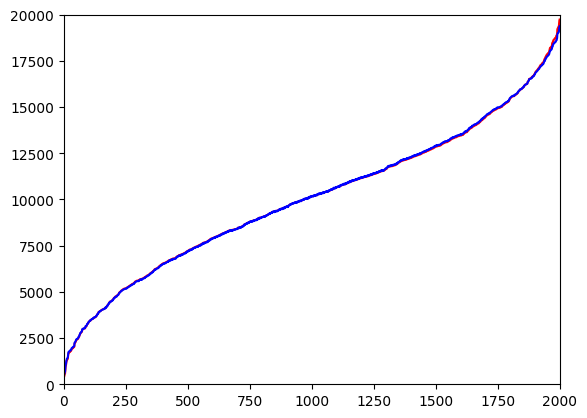

In [6]:
#print result distance
x = [_+1 for _ in range(len(testing_data))]
fig, ax = plt.subplots()
ax.set_xlim(0, len(testing_data))
ax.set_ylim(0, 2e4)
x2, y2 = [], []
line1, = ax.plot(x, testing_label, 'r', label="label")
line2, = ax.plot(x2, y2, 'b', label="predict")

def run(d):
    x2 = x
    y2 = d
    line2.set_data(x2, y2)

ani = animation.FuncAnimation(fig, run, frames=preds, interval=100)
ani.save('ani_result.gif', fps=1)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


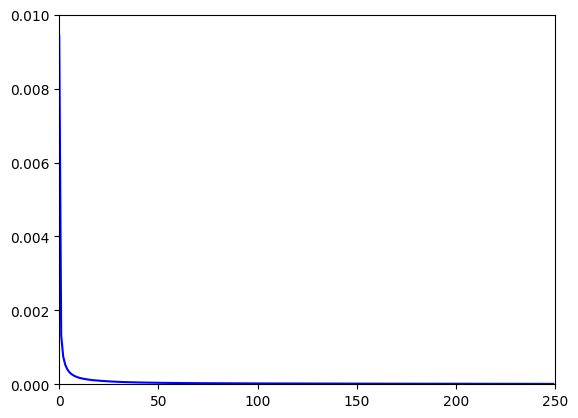

In [11]:
#print loss distance
x = [_ for _ in range(250)]
fig, ax = plt.subplots()
ax.set_xlim(0, 250)
ax.set_ylim(0, 0.01)
x2, y2 = [], []
line2, = ax.plot(x2, y2, 'b', label="predict")

def run(d):
    x2.append(d)
    y2.append(losses[d])
    line2.set_data(x2, y2)

ani = animation.FuncAnimation(fig, run, frames=x, interval=100)
ani.save('ani_loss.gif', fps=25)
plt.show()

In [10]:
losses[0]

0.00942877615250001